In [1]:
# if you need to plot anything
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore')

## Predict Wine Ratings

The main idea is to predict the wine ratings based on the expert reviews that are usually presented in a narrative.

In [2]:
import re
import nltk
import pandas as pd
import numpy as np
from nltk import download, wordnet
nltk.download('omw-1.4')
download('punkt')
download('stopwords')
download("wordnet")

#from nltk.corpus import stopwords
import gensim
from gensim.parsing.preprocessing import remove_stopwords

# For lemmatization
lemma = wordnet.WordNetLemmatizer()

# For stemming
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

# For showing progress bars in long for-loops
from tqdm import tqdm

#import CountVectorizer if we just want a Bag of Words Model
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# import some classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import accuracy_score as AC, confusion_matrix as CM, ConfusionMatrixDisplay as CMD

[nltk_data] Downloading package omw-1.4 to /home/dvasiliu/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /home/dvasiliu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dvasiliu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/dvasiliu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


ModuleNotFoundError: No module named 'gensim'

In [40]:
wine_data = pd.read_csv('drive/MyDrive/Data Sets/winemagdata130kv2.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [41]:
wine_data.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [42]:
wine_data.description[0]

"Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity."

In [43]:
wine_data.description[1]

"This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's  already drinkable, although it will certainly be better from 2016."

In [ ]:
len(wine_data.points.unique())

21

Project:

- the target variable is the "points"
- the input variables include the "description"

Critical Thinking: do we need more input features?

In [44]:
wine_subset = wine_data[['description','points']]
# if you need to subset the big data
# wines_subset = wine_subset.sample(20000,random_state=310).reset_index(drop=True)

In [45]:
wine_subset.head()

,description,points
0,"Aromas include tropical fruit, broom, brimston...",87
1,"This is ripe and fruity, a wine that is smooth...",87
2,"Tart and snappy, the flavors of lime flesh and...",87
3,"Pineapple rind, lemon pith and orange blossom ...",87
4,"Much like the regular bottling from 2012, this...",87


In [46]:
wine_subset.sample(4,random_state=1234).reset_index(drop=True)

,description,points
0,This high-end bottling features fruit from 90+...,86
1,"Mild citrus and grassy aromas are quiet, while...",82
2,"Very ripe, rich and oaky, made solidly in the ...",88
3,This medium-sweet wine is attractively perfume...,86


##<font color='blue' size=7pt>Trick to make text pre-processing faster

In [ ]:
wine_subset.description[0]

"Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity."

In [47]:
# this is the trick: we included a fakeword at the end of each row for the reviews
reviews = wine_subset.description.values + ' '+'fakeword'+' '

In [48]:
joined_reviews = ' '

for i in tqdm(range(len(reviews))):
  joined_reviews = joined_reviews+reviews[i]

100%|██████████| 129971/129971 [00:01<00:00, 125958.61it/s]


In [49]:
# here in joined_reviews we got a monster long sentence!
joined_reviews[:500]

" Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity. fakeword This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's  already drinkable, although it will certainly be better from 2016. fakeword Tart and snappy, the flavors of lime flesh and rind dominate. Some green pineapp"

In [50]:
# here we do the text pre-processing very fast
# remove punctuation
wine_descriptions = re.sub('[^a-zA-Z0-9 ]','',joined_reviews)
# remove stopwords
wine_descriptions = remove_stopwords(wine_descriptions.lower())
# next we can stem or lemmatize
wine_descriptions = [lemma.lemmatize(word) for word in wine_descriptions.split()]

In [51]:
wine_descriptions = " ".join(wine_descriptions)

In [52]:
documents = wine_descriptions.split('fakeword')

In [53]:
documents[-1]

''

In [54]:
documents = documents[:-1]

In [57]:
documents[0]

'aroma include tropical fruit broom brimstone dried herb palate isnt overly expressive offering unripened apple citrus dried sage alongside brisk acidity '

In [56]:
len(documents)

129971

###<font color='blue'> We create a function for fast text pre-processing

In [ ]:
def text_preprocess(original_documents):
  reviews = original_documents.values + ' '+'fakeword'+' '
  joined_reviews = ' '
  for i in range(len(reviews)):
    joined_reviews = joined_reviews+reviews[i]
  # here we do the text pre-processing very fast
  # remove punctuation
  descriptions = re.sub('[^a-zA-Z0-9 ]','',joined_reviews)
  # remove stopwords
  descriptions = remove_stopwords(wine_descriptions.lower())
  # we can use Porter Stemmer or we can Lemmatize
  # for Porter Stemmer
  descriptions = [stemmer.stem(word) for word in descriptions.split()]
  # next we can stem or lemmatize
  #descriptions = [lemma.lemmatize(word) for word in descriptions.split()]
  descriptions = " ".join(descriptions)
  documents = wine_descriptions.split('fakeword')
  documents = documents[:-1]
  return documents

In [ ]:
documents = text_preprocess(wine_subset.description)

## Binning the Classes

In [ ]:
pts = wine_subset.points
y = pts.copy().values
y[pts>=92] = 4
y[(pts>=90) & (pts<=91)] = 3
y[(pts>=88) & (pts<=89)] = 2
y[(pts>=86) & (pts<=87)] = 1
y[(pts>=80) & (pts<=85)] = 0

Message: If we make fewer categories we can see an improvement in prediction.

In [58]:
pts = wine_subset.points
y = pts.copy().values
y[pts>=93] = 2
y[(pts>=88) & (pts<=92)] = 1
y[(pts<=87)] = 0


## Assemble the preprocessed data

In [ ]:
df = pd.DataFrame(data=documents,columns = ['Reviews'])
df['Category'] = y

In [59]:
df.head()

,Reviews,Category
0,aroma include tropical fruit broom brimstone d...,0
1,ripe fruity wine smooth structured firm tanni...,0
2,tart snappy flavor lime flesh rind dominate g...,0
3,pineapple rind lemon pith orange blossom star...,0
4,like regular bottling 2012 come rough tannic ...,0


In [60]:
# here we can make a TF-IDF approach
vectorizer = TfidfVectorizer()
x = vectorizer.fit_transform(df['Reviews'])

In [61]:
x.shape

(129971, 42813)

## Choose a Classifier

In [62]:
model = LogisticRegression(solver='lbfgs',max_iter=10000)

In [63]:
model.fit(x,y)

LogisticRegression(max_iter=10000)

In [64]:
ypred = model.predict(x)

In [65]:
pd.DataFrame(data=CM(y,ypred),index=['0','1','2'],columns=['0','1','2'])

,0,1,2
0,41620,9853,20
1,7720,56985,1110
2,93,6972,5598


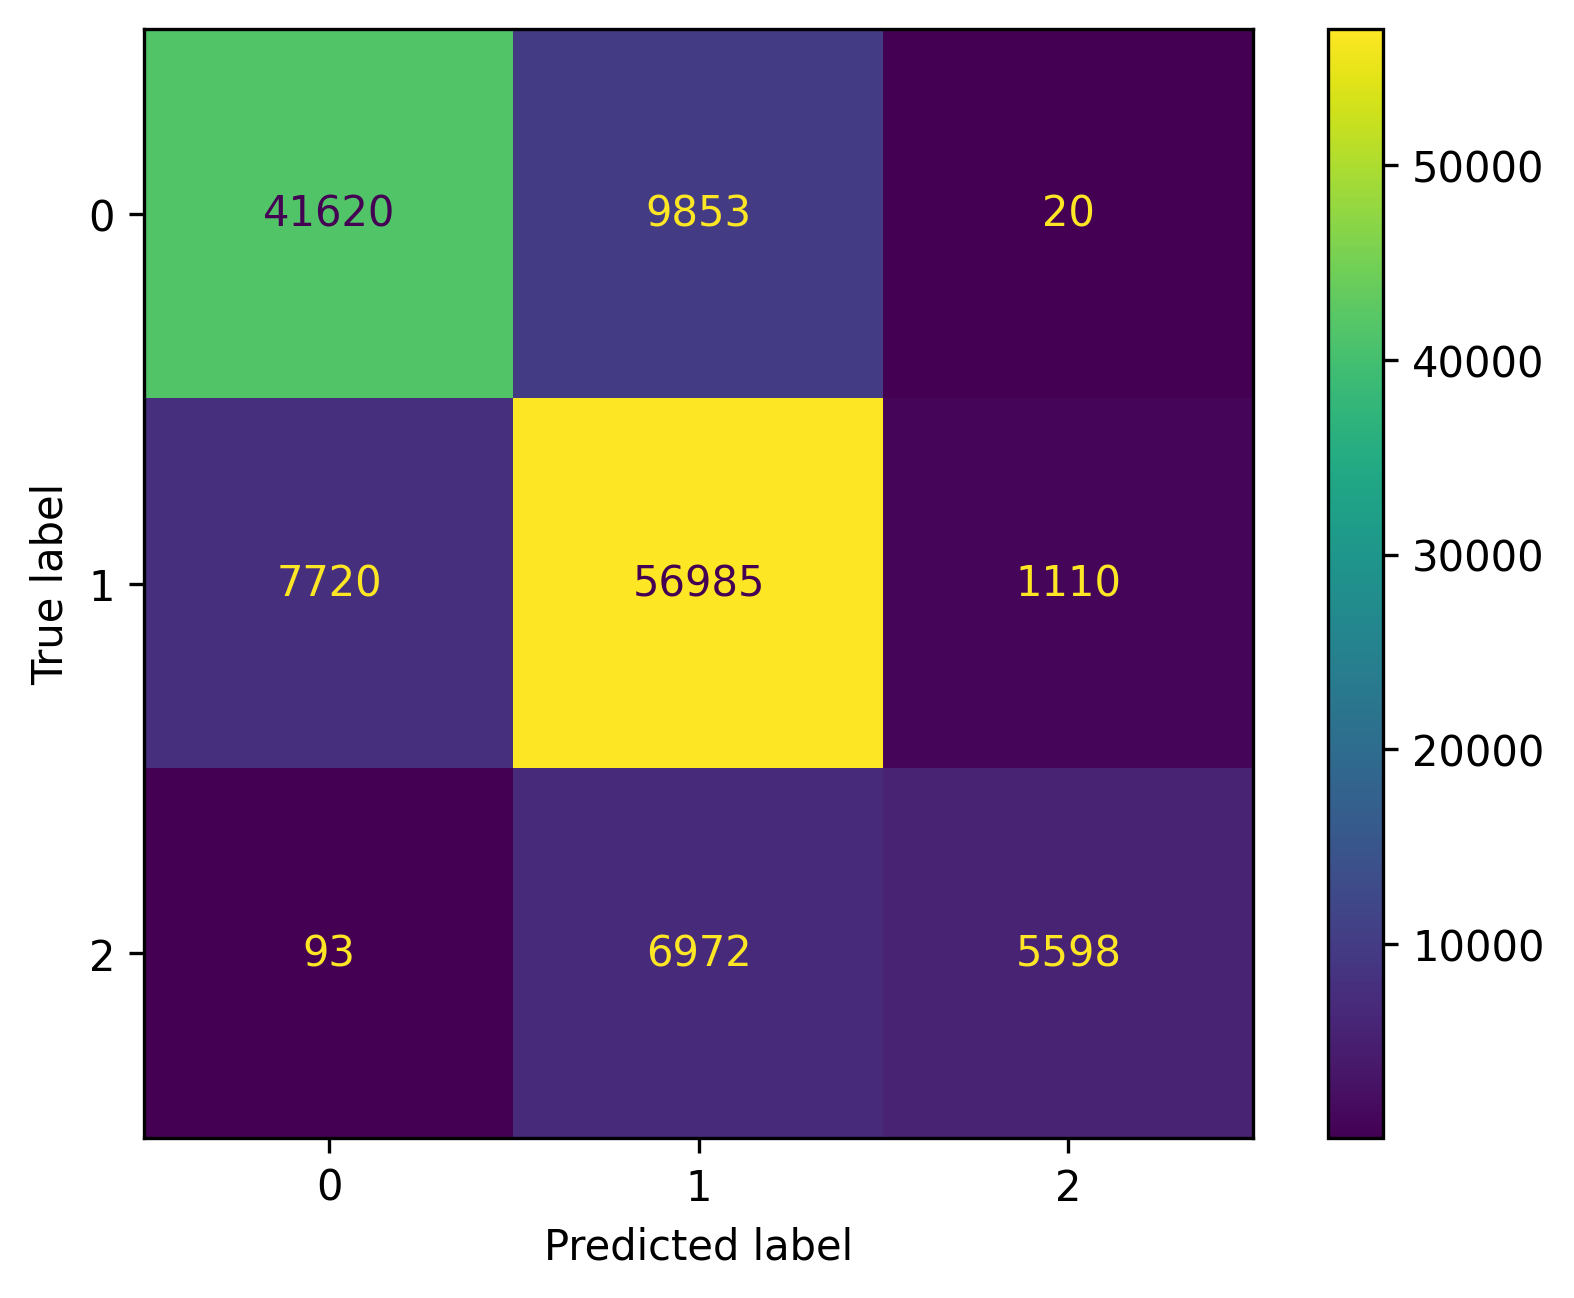

In [66]:
CMD(CM(y,ypred)).plot()
plt.show()

In [ ]:
AC(y,ypred)

0.8017403882404537

###<font color='blue'>Optional: we may need to create smaller subsets for testing different models

In [ ]:
small_subset = pd.concat([df.loc[df['Category']==0].sample(5000),df.loc[df['Category']==1].sample(5000),
                         df.loc[df['Category']==2].sample(5000)]).reset_index()

In [ ]:
# here we can make a TF-IDF approach
vectorizer = TfidfVectorizer()
x = vectorizer.fit_transform(small_subset['Reviews'])

---

## Test Different Classifiers

In this section we test different classifiers such as Logistic Regression, KNeearestNeighbors and Random Forest

In [ ]:
y = small_subset['Category'].values

In [ ]:
model = LogisticRegression(solver='lbfgs',max_iter=10000)

In [67]:
def modelvalidation(model,x,y,nfolds=5,rs=123):
  skf = StratifiedKFold(n_splits=nfolds,shuffle=True,random_state=rs)
  accuracies = []
  confusions = []

  for idxtrain, idxtest in skf.split(x,y):
    xtrain = x[idxtrain]
    ytrain = y[idxtrain]
    xtest = x[idxtest]
    ytest = y[idxtest]
    model.fit(xtrain,ytrain)
    accuracies.append(AC(ytest,model.predict(xtest)))
    print(accuracies)
    confusions.append(CM(ytest,model.predict(xtest)))
  return accuracies, confusions, np.mean(accuracies)

In [ ]:
modelvalidation(model,x,y,5,1234)

[0.7539526832083093]
[0.7539526832083093, 0.751596522274371]
[0.7539526832083093, 0.751596522274371, 0.7540970993306148]
[0.7539526832083093, 0.751596522274371, 0.7540970993306148, 0.7535200430868662]
[0.7539526832083093, 0.751596522274371, 0.7540970993306148, 0.7535200430868662, 0.7543279218281141]


([0.7539526832083093,
  0.751596522274371,
  0.7540970993306148,
  0.7535200430868662,
  0.7543279218281141],
 [array([[ 7890,  2407,     2],
         [ 1953, 10889,   321],
         [   27,  1686,   820]]),
  array([[ 7874,  2421,     4],
         [ 1966, 10863,   334],
         [   25,  1707,   800]]),
  array([[ 7904,  2388,     7],
         [ 1985, 10859,   319],
         [   25,  1668,   839]]),
  array([[ 7832,  2457,     9],
         [ 1913, 10891,   359],
         [   22,  1647,   864]]),
  array([[ 7935,  2361,     2],
         [ 1989, 10850,   324],
         [   22,  1688,   823]])],
 0.7534988539456551)

In [ ]:
model = KNeighborsClassifier(n_neighbors=15,weights='distance')

In [ ]:
model = RandomForestClassifier(n_estimators=200,max_depth=100)

In [ ]:
modelvalidation(model,x,y,5,123)

[0.7414502788997884]
[0.7414502788997884, 0.7364776486881588]
[0.7414502788997884, 0.7364776486881588, 0.734784950373163]
[0.7414502788997884, 0.7364776486881588, 0.734784950373163, 0.7370162345156575]
[0.7414502788997884, 0.7364776486881588, 0.734784950373163, 0.7370162345156575, 0.7359775332769101]


([0.7414502788997884,
  0.7364776486881588,
  0.734784950373163,
  0.7370162345156575,
  0.7359775332769101],
 [array([[ 7393,  2906,     0],
         [ 1416, 11746,     1],
         [   12,  2386,   135]]), array([[ 7354,  2945,     0],
         [ 1515, 11646,     2],
         [   10,  2378,   144]]), array([[ 7241,  3058,     0],
         [ 1459, 11704,     0],
         [   13,  2364,   155]]), array([[ 7356,  2942,     0],
         [ 1497, 11665,     1],
         [   12,  2384,   137]]), array([[ 7346,  2952,     0],
         [ 1520, 11643,     0],
         [   10,  2381,   142]])],
 0.7371413291507356)